# Making the trainig sample from CANDELS GOODS-S 

By Shooby, last edited Oct 21 2019



In [1]:
import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import astropy.wcs as wcs
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import ndimage
from PIL import Image


%matplotlib inline

# High resolution GOODS-S galaxies to H<=26 and z<2

In [2]:
gs = pyfits.getdata('../../WFIRST_WPS/CANDELS_fits/gds.fits')
sel1 = (gs['zbest']>0.01)&(gs['zbest']<6.0)&(gs['CLASS_STAR']<0.9)&(gs['Hmag']<25.)&(gs['ISOAREA_IMAGE_F160W']>=5)#&(gs['B_IMAGE_1']/gs['A_IMAGE_1']>0.6)

print (len(gs[sel1]))

9885


In [3]:
def radec2xy(ra,dec,wc):
    coords = SkyCoord(ra,dec, unit='deg')
    a=wcs.utils.skycoord_to_pixel(coords, wc, origin=0,mode=u'wcs')
    return a[0],a[1]
    
def cut(ra,dec,andaze,filename):
    '''gets coordinates of the galaxy and the filter to return a cutout
    (also called a postage stamp) of the galaxy with given size'''
    hdr = pyfits.getheader(filename)
    w = wcs.WCS(hdr)
    x,y=radec2xy(ra,dec,w)
    x,y=np.int(x),np.int(y)
    im=pyfits.getdata(filename)[y-andaze:y+andaze,x-andaze:x+andaze]
    return im


In [7]:
#GOODS-S all
ra1,dec1=gs['RA_1'][sel1],gs['DEC_1'][sel1]

im = np.zeros([64,64])
for boz in range(3000):
    n = np.int(np.random.uniform(0,len(ra1)-1))
    data = cut(ra1[n],dec1[n],50,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f814w_060mas_v1.5_drz.fits')
    if data[0,0]!=0 :
        angle = np.random.uniform(0,180)
        s = ndimage.rotate(data,angle,mode='nearest',reshape=False)
        da = np.arcsinh(s[18:-18,18:-18])
        rescaled = (255.0 / (da.max()+0.1) * (da - da.min())).astype(np.uint8)
        im = Image.fromarray(rescaled)
        im.save('images/training_images/1/'+str(boz)+'.jpg')
    
    n = np.int(np.random.uniform(0,len(ra1)-1))
    data = cut(ra1[n],dec1[n],50,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f814w_060mas_v1.5_drz.fits')
    if data[0,0]!=0 :
        angle = np.random.uniform(0,180)
        s = ndimage.rotate(data,angle,mode='nearest',reshape=False)
        da = np.arcsinh(s[18:-18,18:-18])
        rescaled = (255.0 / (da.max()+0.1) * (da - da.min())).astype(np.uint8)
        im = Image.fromarray(rescaled)
        im.save('images/training_images/2/'+str(boz)+'.jpg')

    

KeyboardInterrupt: 

In [7]:
#GOODS-S all
ra1,dec1=gs['RA_1'][sel1],gs['DEC_1'][sel1]

im = np.zeros([64,64])
for boz in range(1000):
    n = np.int(np.random.uniform(0,len(ra1)-1))
    data = cut(ra1[n],dec1[n],50,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f814w_060mas_v1.5_drz.fits')
    if data[0,0]!=0 :
        angle = np.random.uniform(0,180)
        s = ndimage.rotate(data,angle,mode='nearest',reshape=False)
        da = np.arcsinh(s[18:-18,18:-18])
        rescaled = (255.0 / (da.max()+0.1) * (da - da.min())).astype(np.uint8)
        im = Image.fromarray(rescaled)
        im.save('images/test_images/1/'+str(boz)+'.jpg')
    
    n = np.int(np.random.uniform(0,len(ra1)-1))
    data = cut(ra1[n],dec1[n],50,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f814w_060mas_v1.5_drz.fits')
    if data[0,0]!=0 :
        angle = np.random.uniform(0,180)
        s = ndimage.rotate(data,angle,mode='nearest',reshape=False)
        da = np.arcsinh(s[18:-18,18:-18])
        rescaled = (255.0 / (da.max()+0.1) * (da - da.min())).astype(np.uint8)
        im = Image.fromarray(rescaled)
        im.save('images/test_images/2/'+str(boz)+'.jpg')
  

In [10]:
# optim 
sel1 = (gs['zbest']>0.1)&(gs['zbest']<0.9)&(gs['CLASS_STAR']<0.8)&(gs['Hmag']<25.5)&(gs['ISOAREA_IMAGE_F160W']>=200)&(gs['B_IMAGE_1']/gs['A_IMAGE_1']>0.4)
#sel1 = (gs['zbest']>0.1)&(gs['zbest']<1.5)&(gs['CLASS_STAR']<0.8)&(gs['Hmag']<25.5)&(gs['ISOAREA_IMAGE_F160W']>=100)&(gs['B_IMAGE_1']/gs['A_IMAGE_1']>0.5)
print (len(gs[sel1]))

1000


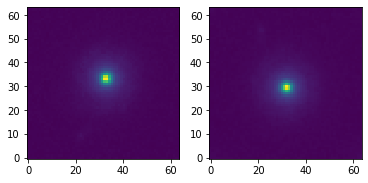

In [11]:
boz=100


ra1,dec1=gs['RA_1'][sel1],gs['DEC_1'][sel1]
data = cut(ra1[boz],dec1[boz],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f814w_060mas_v1.5_drz.fits')
#da = percentile_normalization(data)
da = np.arcsinh(data)
#da[np.isnan(da)]=0
#da[da<0]=0
rescaled = (255.0 / (da.max()+0.1) * (da - da.min())).astype(np.uint8)
plt.subplot(1,2,1)
plt.imshow(rescaled,origin='lower')
plt.subplot(1,2,2)
import scipy
s = ndimage.rotate(rescaled,np.random.uniform(0,180),mode='mirror',reshape=False)
plt.imshow(s,origin='lower')

In [15]:
ra1,dec1=gs['RA_1'][sel1],gs['DEC_1'][sel1]

im = np.zeros([64,64])
for boz in range(2500):
    n = np.int(np.random.uniform(0,len(ra1)-1))
    data = cut(ra1[n],dec1[n],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f814w_060mas_v1.5_drz.fits')
    if data[0,0]!=0 :
        #da = percentile_normalization(data)
        da = np.arcsinh(data)
        rescaled = (255.0 / (da.max()+0.1) * (da - da.min())).astype(np.uint8)
        angle = np.random.uniform(0,180)
        s = ndimage.rotate(rescaled,angle,mode='nearest',reshape=False)
        im = Image.fromarray(s)
        im.save('images/training_images/1/'+str(boz)+'.jpg')
    
    n = np.int(np.random.uniform(0,len(ra1)-1))
    data = cut(ra1[n],dec1[n],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f814w_060mas_v1.5_drz.fits')
    if data[0,0]!=0 :
        da = np.arcsinh(data)
        #da = percentile_normalization(data)
        rescaled = (255.0 / (da.max()+0.1) * (da - da.min())).astype(np.uint8)
        angle = np.random.uniform(0,180)
        s = ndimage.rotate(rescaled,angle,mode='nearest',reshape=False)
        im = Image.fromarray(s)
        im.save('images/training_images/2/'+str(boz)+'.jpg')
    

    

KeyboardInterrupt: 

In [14]:
ra1,dec1=gs['RA_1'][sel1],gs['DEC_1'][sel1]

im = np.zeros([64,64])
for boz in range(1000):
    n = np.int(np.random.uniform(0,len(ra1)-1))
    data = cut(ra1[n],dec1[n],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f814w_060mas_v1.5_drz.fits')
    if data[0,0]!=0 :
        da = np.arcsinh(data)
        #da = percentile_normalization(data)
        rescaled = (255.0 / (da.max()+0.1) * (da - da.min())).astype(np.uint8)
        angle = np.random.uniform(0,180)
        s = ndimage.rotate(rescaled,angle,mode='nearest',reshape=False)
        im = Image.fromarray(s)
        im.save('images/test_images/1/'+str(boz)+'.jpg')
    
    n = np.int(np.random.uniform(0,len(ra1)-1))
    data = cut(ra1[n],dec1[n],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f814w_060mas_v1.5_drz.fits')
    if data[0,0]!=0 :
        da = np.arcsinh(data)
        # da = percentile_normalization(data)
        rescaled = (255.0 / (da.max()+0.1) * (da - da.min())).astype(np.uint8)
        angle = np.random.uniform(0,180)
        s = ndimage.rotate(rescaled,angle,mode='nearest',reshape=False)
        im = Image.fromarray(s)
        im.save('images/test_images/2/'+str(boz)+'.jpg')

# Low resolution sample 
I do this in the GAN now <br>

    a) pixel-scale from 0.06"/pix to 0.18"/pix
    b) psf from ~0.18"? to 0.6"
    c) noise 